### MINST DIGIT CLASSIFIATION

Foundational machine learning classification workflow
* Image data handling
* Supervised classification model
* Classification metrics


In [1]:
# LOAD LIBRARIES
from joblib import load, dump
import numpy as np
import pandas as pd

In [2]:
# FETCH DATA FROM PREVIOUS DUMP
minst = load('./repository/MINST_ORIGINAL.txt')

In [3]:
minst.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X = minst['data']
y = minst['target']

In [5]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


* data has 70000 images of handwritten digits and 784 features, which indicates 28x28 pixels grid of each image

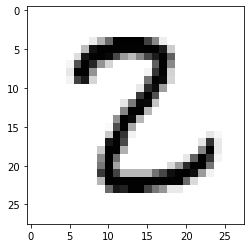

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# DISPLAY A SAMPLE DIGIT
sample_digit = X[3200].reshape(28, 28)
plt.imshow(sample_digit, cmap=matplotlib.cm.binary, interpolation='nearest')

In [7]:
# VERIFY NUMBER == 2
y[3200]

'2'

* It is a good practice to first separate training and testing data before carrying out further analysis on the data.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# SPLIT DATA IN A STRATIFIED FASHION, USING THE LABELS AS THE KEY.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.14, stratify=y, random_state=42)

In [10]:
def checkFraction(**kwargs):
    display_split_fraction = pd.DataFrame()
    for label, data in kwargs.items():
        fractions = []
        for i in range(10): # For each digit instance
            count_value = data.tolist().count(str(i))
            fractions.append(round(count_value/len(data), 2))
        display_split_fraction[label] = fractions
    return display_split_fraction

In [11]:
checkFraction(original=y, training=y_train, test=y_test)

,original,training,test
0,0.10,0.10,0.10
1,0.11,0.11,0.11
2,0.10,0.10,0.10
3,0.10,0.10,0.10
4,0.10,0.10,0.10
5,0.09,0.09,0.09
6,0.10,0.10,0.10
7,0.10,0.10,0.10
8,0.10,0.10,0.10
9,0.10,0.10,0.10


* Similar fraction ensures well represented caetegories in both train and test data

#### Binary Classification
Training Binary Classifier ( 2-detector )
* Performing a simple binary classification, to study the nature  of classification tasks and their model vailidation techniques

In [12]:
y_train_2 = (y_train == "2")
y_test_2 = (y_test == "2")

In [13]:
# Using STOCHASTIC GRADIENT DECENT Classifier
from sklearn.linear_model import SGDClassifier

In [14]:
# Classifier instance
sgd_clf = SGDClassifier(random_state=42)
# Train the classifier
sgd_clf.fit(X_train, y_train_2)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict(sample_digit.reshape(1, 784))

array([ True])

* The `sdg` model predicted the sample digit earlier as a "2". [correct]

#### Model Evaluation
We evaluate this model to see if its predictions are consistently valid

In [17]:
# Using Cross-Validation Techniqe and "accuracy" as Scoring Metrics
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(sgd_clf, X_train, y_train_2, cv=3, scoring='accuracy')

In [19]:
def print_scores(cv_scores):
    print(cv_scores.tolist(),'\n Mean CrossValidation Score: ', np.round(np.mean(cv_scores), 2))
    
print_scores(cv_scores)

[0.9723426521154134, 0.9574902820691717, 0.9738861756204525] 
 Mean CrossValidation Score:  0.97


* Benchmarking the model with a naive "Never2Classifier" created using sklearn's API

In [20]:
from sklearn.base import BaseEstimator

class Never2Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_2_clf = Never2Classifier()
print_scores(cross_val_score(never_2_clf, X_train, y_train_2, 
                             cv=3, scoring='accuracy'))

[0.9001843823192306, 0.9007275989235523, 0.8995315458985348] 
 Mean CrossValidation Score:  0.9


* there is an obvious skewdness (weigh more non-2s than 2s) in the data and "accuracy" is not a suitable metric for analyzing the performance of this model

* Hence, we use the `Confusion Matrix` to better understand the binary classifier

In [21]:
# Generate Preditions using cross_val_predict
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

def confusion_dataframe(pred, labels):
    frame = pd.DataFrame(confusion_matrix(pred, labels), 
                        columns=['negative_pred', 'positive_pred'],
                        index=['negative_class', 'positive_class'])
    frame['Total'] = [sum(frame.loc['negative_class'].tolist()), 
                      sum(frame.loc['positive_class'].tolist())]
    return frame

confusion_dataframe(y_train_2, y_train_pred)

,negative_pred,positive_pred,Total
negative_class,53064,1124,54188
positive_class,808,5203,6011


confusion matrix for binary classifier
* True Negatives = `53064`
* True Positives = `5203`
* False Postives = `1124`
* False Negatives = `808`


In [23]:
from sklearn.metrics import precision_score, recall_score

In [24]:
 num2percent = lambda x: str(np.round(x*100, 2))+"%"

In [25]:
# precision score
num2percent(precision_score(y_train_2, y_train_pred))

'82.23%'

* 82.23% precision (when a 2 is predicted, the classifier is only 82.23% sure)

In [26]:
num2percent(recall_score(y_train_2, y_train_pred))

'86.56%'

* 86.56% recall (the classifier only captured 86.56% percent of the actual 2s) 

#### Other classification metrics

* F-score : Calculates the harmonic mean (more weight to lower values) of the precision and recall scores

In [27]:
from sklearn.metrics import f1_score

num2percent(f1_score(y_train_2, y_train_pred))

'84.34%'

`Note`: The F1 score gives a higher value when precison and recall are similar. Such functionality made need to be analyzed thoroughly for different use cases

#### Examining the Precision/Recall Trade-off

* Using the decision function of the SDG Classifier, we can get the determinig factor in which the model classifies input data

In [28]:
y_thresh = cross_val_predict(sgd_clf, X_train, y_train_2, cv=5, method='decision_function')

In [29]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_train_2, y_thresh)

In [30]:
def plot_precision_recall_curve(precision, recall, thresholds):
    plt.figure(figsize=(10, 4))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.ylim([0, 1])
    plt.xlim([min(thresholds), max(thresholds)])
    plt.legend(loc='center left')
    plt.title('Precision/Recall Curve')
    

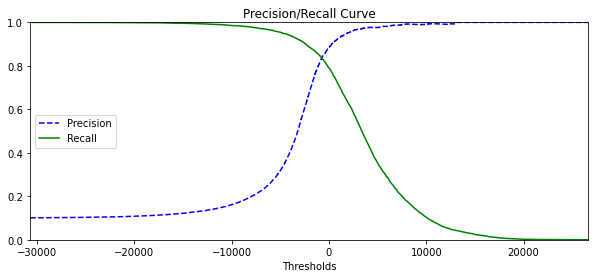

In [31]:
plot_precision_recall_curve(precision, recall, thresholds)

* The trade-off is clear. Hence adequate threshold should be use for various tasks

In [32]:
def precision_vs_recall(precision, recall):
    plt.plot(recall, precision)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.xlim([0, 1])
    plt.xlim([0, 1])

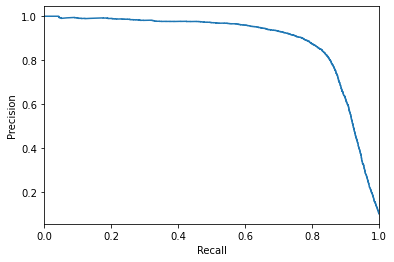

In [33]:
precision_vs_recall(precision, recall)

#### Reciever Operating Characteristics (ROC)
* TPR (True Positive Rate) Vs FPR (False Positive Rate)

In [34]:
from sklearn.metrics import roc_curve

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, 'r', linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')

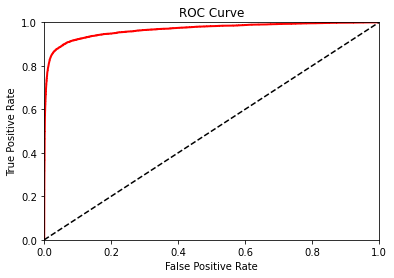

In [36]:
fpr, tpr, _ = roc_curve(y_train_2, y_thresh)
plot_roc_curve(fpr, tpr)

* The dotted line illustrates a purely random classifier. The ROC curve (Red Plot) should be far away from the dotted line for a better model

In [37]:
from sklearn.metrics import roc_auc_score

In [39]:
roc_auc_score(y_train_2, y_thresh)

0.9669908058498152

* We train a RandomForestClassifier and compare its performance with the SDG Classifier using the ROC, and ROC AUC

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rnd_forest = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rnd_forest, X_train, y_train_2, cv=3,
                                   method='predict_proba')

In [46]:
y_probas_forest = y_probas_forest[:, 1]  # using positive class as the score

In [47]:
fpr_forest, tpr_forest, _ = roc_curve(y_train_2, y_probas_forest)

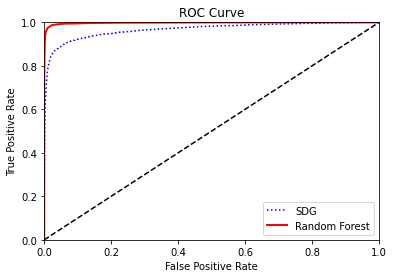

In [49]:
plt.plot(fpr, tpr, 'b:', label='SDG')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc="lower right")

In [50]:
roc_auc_score(y_train_2, y_probas_forest)

0.9978374103445128

* It is shown that the ensemble RandomForest Model outperforms the SDG classifier, with a better roc curve (farther away from the naive random model "diagonal line") and an AUC score of 0.99, as oppose to 0.966 of the SDG Classifier

#### MultiClass Classification
* OneVsOne and OneVsAll Classification Tasks

In [52]:
from sklearn.multiclass import OneVsOneClassifier

In [53]:
sdg_multi = SGDClassifier(random_state=42)
sdg_multi.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [58]:
sample_digit = X[3200]
sdg_multi.predict([sample_digit])

array(['2'], dtype='<U1')

In [64]:
np.argmax(sdg_multi.decision_function([sample_digit]))

2

* scikit learn automatically uses `OneVsAll` Technique for Linear Classifiers
This default behaviour can be altered by using the `OneVsOneClassifier` sklearn class

In [69]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([sample_digit])

array(['2'], dtype=object)

In [70]:
len(ovo_clf.estimators_)

45

* 45 estimators are trained, since there are 10 classes
N (N-1)/2

In [71]:
# Train the RandomForest Algrorithm
tree_multi = RandomForestClassifier()
tree_multi.fit(X_train, y_train)

RandomForestClassifier()

* RandomForest is capable of handling multiclass classification by default, due to its non-linear nature

In [72]:
tree_multi.predict([sample_digit])

array(['2'], dtype=object)

In [74]:
# Look up prediction probabilites
prob = tree_multi.predict_proba([sample_digit])
prob

array([[0.  , 0.  , 0.93, 0.03, 0.  , 0.  , 0.02, 0.  , 0.02, 0.  ]])

In [75]:
np.argmax(prob) # The highest Probability is the predicted outcome

2

#### Evaluating MultiClass Classification

* CrossValidation definetely works here

In [86]:
def evaluate(X, y, model):
    sgd = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    return np.mean(sgd)

In [88]:
print('SGD Classifier', evaluate(X_train, y_train, sdg_multi))
print('RandomForest', evaluate(X_train, y_train, tree_multi))

SGD Classifier 0.8790178810483534
RandomForest 0.9664114137536922


* Evaluating on scaled versions of the data

In [91]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [92]:
print('SGD Classifier', evaluate(X_scaled, y_train, sdg_multi))
print('RandomForest', evaluate(X_scaled, y_train, tree_multi))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD Classifier 0.902473467927428
RandomForest 0.9658299916383806


#### Error Analysis

In [93]:
y_train_pred = cross_val_predict(tree_multi, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

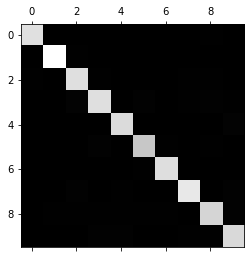

In [94]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

* The plot nee\ds to be focused on prediction errors

In [96]:
conf_mx

array([[5855,    0,    6,    3,    2,    9,   24,    1,   32,    5],
       [   0, 6663,   41,   12,    9,    7,    7,   15,   14,    6],
       [  31,   10, 5813,   29,   23,    2,   21,   38,   37,    7],
       [   9,    8,   86, 5819,    4,   65,    7,   47,   58,   38],
       [   7,   11,   11,    0, 5701,    0,   26,    9,   12,   92],
       [  22,   10,   10,   71,   14, 5205,   38,    4,   31,   24],
       [  24,   15,    4,    0,   10,   43, 5799,    0,   18,    0],
       [   5,   23,   70,    7,   34,    1,    0, 6050,   10,   72],
       [  13,   32,   31,   49,   34,   45,   29,    8, 5569,   59],
       [  24,   12,   17,   75,   74,   18,    4,   51,   43, 5666]],
      dtype=int64)

In [98]:
row_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sum

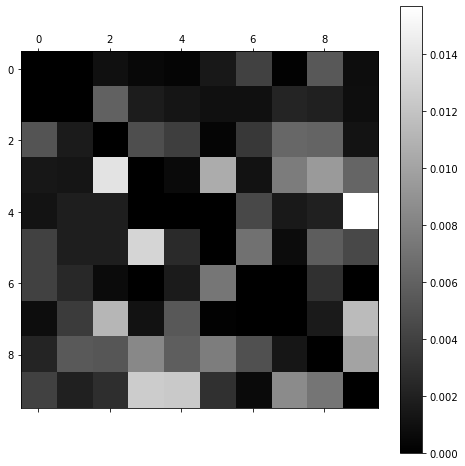

In [109]:
# Fill diagonal with zeros to focus on errors
matfig = plt.figure(figsize=(8,8))
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=matfig.number)
plt.colorbar()

* White boxes indicates higher number of misclassification